# データ分析（1）

《学修項目》
*   ◎回帰分析
*   ロジスティック分析
*   時系列分析

《キーワード》
> 説明変数との関係、予測モデル、最小二乗法、単回帰分析、重回帰分析、次数選択、観測値の非線形変換、ロジット変換、離散変数、尤度、最尤推定量、周期的変動、パワースペクトル、移動平均、季節調整法、自己相関関数、ARモデル


《参考文献，参考書籍》
*   [1] [東京大学MIセンター公開教材 「1-4 データ分析」](http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf)[《利用条件CC BY-NC-SA》](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.ja)
*   [2] [応用基礎としてのデータサイエンス（講談社 データサイエンス入門シリーズ）](https://www.kspub.co.jp/book/detail/5307892.html)
*   [3] [データサイエンスの考え方 社会に役立つAI×データ活用のために（オーム社）](https://www.ohmsha.co.jp/book/9784274227974/)
*   [4] [Pythonによるあたらしいデータ分析の教科書 第2版（翔泳社）](https://www.shoeisha.co.jp/book/detail/9784798178776)
*   [5] [数理・データサイエンス・AI公開講座（放送大学）](https://www.ouj.ac.jp/booklet/2022/29_2022_MDS-AI.pdf)

## 1. 線形回帰分析（量的目的変数）

### 1.1 説明変数との関係 [1]

日本の47都道府県の人口千人あたりの新型コロナウイルスの累積感染者数（2021年4月当時）のデータから、棒グラフによる可視化を行ってみると、都道府県によって感染者の割合が大きく異なることが分かる。

都道府県による感染者の違いを各県の県庁所在地の人口密度と関連づけて説明することを考える（仮説）。

各県の県庁所在地の人口密度を横軸に、千人当たりの感染者数を縦軸にとって散布図を描くと、人口密度と感染者数には明確な関係があることが分かる[1]。

<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=5"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_005.jpg' alt='回帰分析' width='640' border='1'></a>
</figure>


#### Pythonによる散布図プロットの実装例

日本の47都道府県の人口千人あたりの新型コロナウイルスの累積感染者数（2021年4月当時）のデータ

* [オリジナルデータとプログラム例（公開教材[1]ただし実装はR）](https://github.com/MDASH-shinshu/MDASH-T-DS/tree/main/4/resources/additional_material/)

In [ ]:
# CSVデータを カレントディレクトリ直下のフォルダ（一時作業領域）へダウンロードする．
!wget -nc https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/resources/Tokyo_Covid-19_regression.csv

# wgetしなくても，Google colab.の左メニュー [ファイル] アイコンをクリックして，ブラウザへファイルをドラッグ＆ドロップしても可

# ファイル (udon.csv)がダウンロード・配置できたことを確認する
!ls -al ./

In [35]:
# 全ての警告メッセージを非表示（オプション）
import warnings
warnings.simplefilter('ignore')

In [36]:
# オリジナルのCSVファイルをpandasで読み込んでデータフレームdfに格納
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('Tokyo_Covid-19_regression.csv', header=1)
df.columns = ['prefecture','positive_rate','population','density','aging_rate','density_central','2hours','4hours','6hours','8hours']
df.head()

,prefecture,positive_rate,population,density,aging_rate,density_central,2hours,4hours,6hours,8hours
0,青森県,0.63,1308,135.6,30.15,331.16,0.59,6.52,25.98,79.54
1,岩手県,0.43,1280,83.8,30.41,328.63,1.53,13.27,34.97,83.01
2,宮城県,1.59,2334,320.5,25.74,1388.68,1.79,15.37,42.90,78.77
3,秋田県,0.26,1023,87.9,33.92,335.55,0.58,5.72,24.01,75.89
4,山形県,0.48,1124,120.5,30.84,650.37,0.77,7.12,26.92,87.49


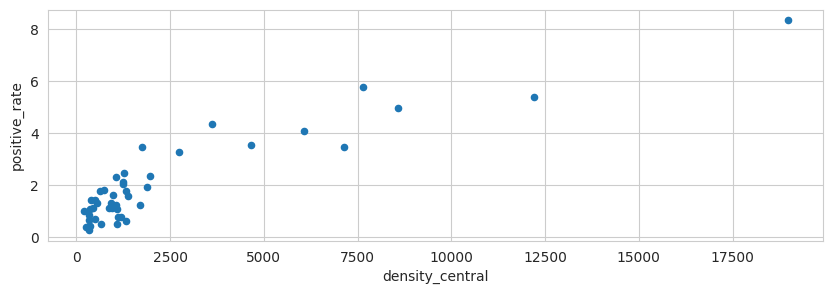

In [37]:
# 散布図 X軸：各県の県庁所在地の人口密度（線形） Y軸：千人当たりの感染者数
df.plot(kind='scatter', grid=True, x=df.columns[5], y=df.columns[1])
plt.show()
## 右上で突出している１点は、東京都である。

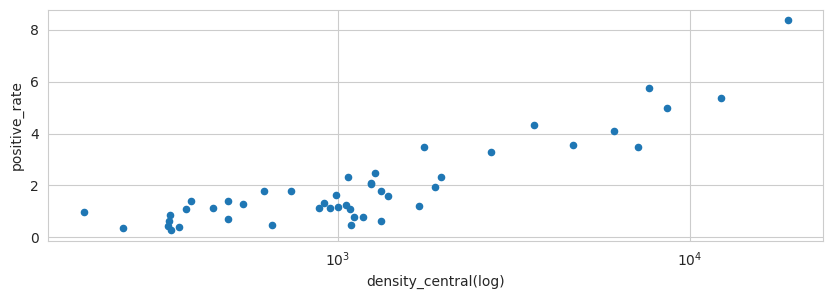

In [38]:
# 散布図 X軸：各県の県庁所在地の人口密度（対数） Y軸：千人当たりの感染者数
df.plot(kind='scatter', grid=True, logx=True, x=df.columns[5], y=df.columns[1])
plt.xlabel("density_central(log)")
plt.show()
## 対数人口密度と、コロナ感染率は、なんとなく比例している感じがする（東京都を除く）

### 1.2 単回帰分析 [2]

コロナの感染率のように、値の変動の様子に興味がある変数 $y$ と、人口密度のように $y$ の変動の要因と考えられる変数 $x$ があると仮定する。
このとき、$y$ を**被説明変数（従属変数）**、$x$ を**説明変数**という。

ここで、$a, b$ を定数として、$x_i$ が与えられたときに $y_i$ の値が

$$ y_i = a + b x_i  + \varepsilon_i$$

という法則（モデル）に従って決まると想定してみる。
ここで、$\varepsilon_i$ は**誤差項**と呼ばれる。
このような表現を**単回帰モデル**(simple regression model)といい、単回帰モデルを用いて $y$ と $x$ の関係を考察する分析を**単回帰分析**（simple regression analysis) という。

単回帰モデルでは、$y$ の変動の主要な決定要因は $x$ であり、$y$ と $x$ との関係は誤差項を除けば直線 $y = a + b x$ で記述（予測）できると想定する。
この直線のことを**回帰直線（回帰式）**という。
回帰直線の切片 $a$ と傾き $b$ は**回帰係数**と呼ばれる[2]。

<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=6"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_006.jpg' alt='回帰分析' width='640' border='1'></a>
</figure>


<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=7"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_007.jpg' alt='回帰分析' width='640' border='1'></a>
</figure>


### 1.3 最小二乗法による回帰係数の決定[2]

データの情報を用いて、回帰直線を求める手続きを**推定**という。

単回帰モデルにおいてある（確率）分布を仮定すると、手元にあるデータは回帰直線の周りに分布しているはずである。
そこで、データに対して「当てはまりのよい直線を回帰直線とする」ことが単純なアイディアとして出てくる。

データに対して当てはまりのよい直線とはどのような直線だろうか。
回帰直線の候補 $y = a + b x$ が与えられたとき、この直線と各データ点 $(x_i, y_i)$ とは

$$ \varepsilon_i = y_i - (a + b x_i) $$

だけ離れていることになる。この $\varepsilon_i$ を **残差(各点誤差)**という。
一般に残差の値が全体的に 0 に近い直線は、直線と各データ点との差が小さく、データヘの当てはまりが良いと言える。全体的な差の総量を評価するため、残差を2乗して和をとった **残差平方和(RSS)** を定義し、このRSS値が最小となるような係数 $a, b$ を求めることは可能である（なぜなら、2次関数は凸であるから）。
このような RSSの最小化 を用いて回帰直線（回帰係数）を求める方法を、**最小二乗法**（ordinary least squares, OLS法）という。RSSが最適化された回帰係数を $\widehat{a}, \widehat{b}$ と表す[2]。



<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=8"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_008.jpg' alt='回帰分析' width='640' border='1'></a>
</figure>


RSSが最適化され、予測モデル $y = \widehat{a} + \widehat{b} x$ が求められたとする。
このとき、$x = x_i$ での予測値を $\widehat{y_i}$ とする。つまり、各点予測は $\widehat{y_i} = \widehat{a} + \widehat{b} x_i$ である。$\bar{y}$ は 全ての点での $y$ の平均値とする。

**総平方和** TSS の定義：
$$ TSS = \sum_{i=1}^{n}(y_i - \bar{y})^2$$

**回帰平方和** ESS の定義：
$$ ESS = \sum_{i=1}^{n}(\widehat{y_i} - \bar{y})^2$$

残差平方和 RSS も含めた3つの平方和の間には、TSS = ESS + RSS という関係がある。
これらの関係から、$y$ の変動全体(ESS)のうち、回帰直線(TSS)で説明できた割合を計算することで、回帰直線にとデータ点との当てはまりの良さを評価できる。この値を**決定係数** $R$ として以下で定義する[2]。

$$ R^2 = ESS/TSS = 1- RSS/TSS$$


#### Pythonによる単回帰分析例：対数コロナ感染率と人口密度の関係

日本の47都道府県の人口千人あたりの新型コロナウイルスの累積感染者数（2021年4月当時）のデータ

* [オリジナルデータとプログラム例（公開教材[1]ただし実装はR）](https://github.com/MDASH-shinshu/MDASH-T-DS/tree/main/4/resources/additional_material/)
* [参考: Seaborn で散布図・回帰モデルを可視化する](
https://pythondatascience.plavox.info/seaborn/%E6%95%A3%E5%B8%83%E5%9B%B3%E3%83%BB%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB)


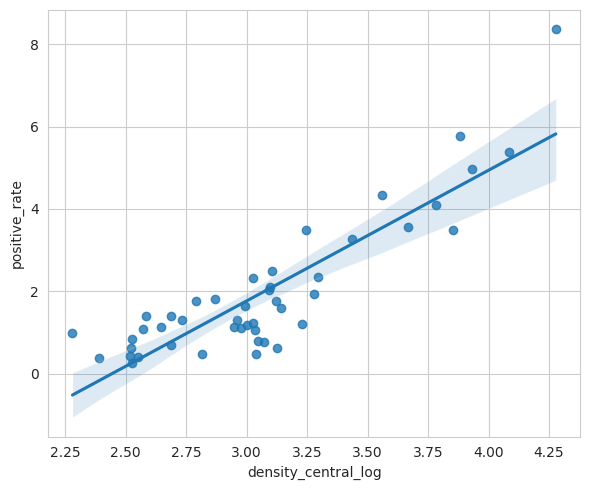

In [39]:
## seaborn regplotで線形回帰直線と信頼区間を描画してみる．
import warnings
warnings.simplefilter('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('Tokyo_Covid-19_regression.csv', header=1)
df.columns = ['prefecture','positive_rate','population','density','aging_rate','density_central','2hours','4hours','6hours','8hours']

# 対数化したxデータ列を追加
df['density_central_log'] = np.log10(df['density_central'] + 1)

x = df.loc[:, ['density_central_log']]
y = df.loc[:, ['positive_rate']]

sns.set_style("whitegrid")
plt.figure(figsize=(6, 5))

sns.regplot(x='density_central_log', y='positive_rate', data=df.loc[:, ['density_central_log','positive_rate']], order=1, ci=95) # seabornを使っての対数化ｘ軸での線形回帰＆信頼区間(95%)の描画を行う
#plt.xscale('log')
plt.tight_layout()
plt.show()

# 予測モデルの信頼区間(95%)から、（上振れ、下振れ両方で）かなり外れている都道府県があるようだ（調べてみよ）。

In [40]:
## scikit-learn を用いた線形回帰の実行例
# sklearn.linear_model.LinearRegression クラスを読み込み
from sklearn import linear_model
clf = linear_model.LinearRegression() # 線形回帰モデラー（教師無し学習）を作る

X = df.loc[:, ['density_central_log']]
Y = df.loc[:, ['positive_rate']]
clf.fit(X, Y) # 線形予測モデルを作成

coef = float(clf.coef_); print(coef) # 回帰係数の表示
intercept = float(clf.intercept_); print(intercept) # 切片 (誤差) の表示
print(clf.score(X, Y)) # 決定係数の表示

# 線形回帰直線による予測関数の定義
def positive_rate_regression(den):
    return float(coef * den + intercept)

3.173743832267236
-7.756488900631577
0.7697379449105892


### 1.4 多項式回帰モデル [1]

単回帰モデルはデータに直線をあてはめるが、入力・出力の関係が直線では十分に表現できない場合、
**多項式回帰モデル**を使うとよいことがある。

ここで、$a_j (j=0,1,\cdots,m)$ を定数として、$x_i$ が与えられたときに $y_i$ の値が

$$ y_i = a_0 + a_1 x_i + \cdots + a_m x^{m}_{i} + \varepsilon_i$$

という法則（モデル）に従って決まると想定する。ここで $m$ は多項式の次数、$a_j$ は回帰係数である[1]。


#### Pythonによる多項式回帰分析例：対数コロナ感染率と人口密度の関係

日本の47都道府県の人口千人あたりの新型コロナウイルスの累積感染者数（2021年4月当時）のデータ

* [オリジナルデータとプログラム例（公開教材[1]ただし実装はR）](https://github.com/MDASH-shinshu/MDASH-T-DS/tree/main/4/resources/additional_material/)
* [参考: Seaborn で散布図・回帰モデルを可視化する](
https://pythondatascience.plavox.info/seaborn/%E6%95%A3%E5%B8%83%E5%9B%B3%E3%83%BB%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB)


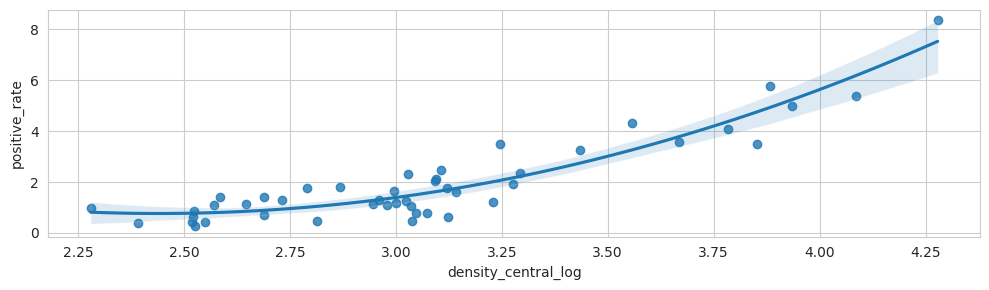

In [41]:
## seaborn regplotで次数order=2の多項式回帰曲線と信頼区間を描画してみる．
sns.regplot(x='density_central_log', y='positive_rate', data=df.loc[:, ['density_central_log','positive_rate']], order=2, ci=95) # seabornを使っての対数化ｘ軸での線形回帰＆信頼区間(95%)の描画を行う
plt.tight_layout()
plt.show()
# 2次の予測モデルの場合、東京度も信頼区間(95%)にギリギリ入る感じになる

In [42]:
## scikit-learn を用いた多項式回帰の実行例
# scikit-learnのPolynomialFeaturesを読み込み
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

X = df.loc[:, ['density_central_log']]
Y = df.loc[:, ['positive_rate']]

# 2次元の特徴量に変換
polynomial_features= PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit_transform(X)

clf = linear_model.LinearRegression() # 線形回帰モデラー（教師無し学習）を作る
clf.fit(X_poly, Y) # 線形予測モデルを作成
Y_pred = clf.predict(X_poly)
 
# 評価
rmse = np.sqrt(mean_squared_error(Y, Y_pred)) #RMSE 二乗平均平方根誤差を計算
r2 = r2_score(Y, Y_pred) #R 決定係数を計算
print(f'RMSE : {rmse}')
print(f'R2 : {r2}')
print(clf.coef_); # 回帰係数の表示

RMSE : 0.6023220609772968
R2 : 0.8695361540597994
[[ 0.         -9.77240526  2.002669  ]]


### 1.5 過学習（Overfitting）、次数選択

<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=12"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_012.jpg' alt='回帰分析' width='640' border='1'></a>
</figure>


<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=13"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_013.jpg' alt='回帰分析' width='640' border='1'></a>
</figure>


<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=14"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_014.jpg' alt='回帰分析' width='640' border='1'></a>
</figure>


<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=15"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_015.jpg' alt='回帰分析' width='640' border='1'></a>
</figure>


### 1.6 重回帰モデル [1]

単回帰モデルは説明変数1つ：従属変数1つの関係性の解析であるが、説明変数を複数にして（選択した）場合の入力・出力の関係を表す予測モデルは、**重回帰モデル**を使うとよいことがある（説明変数の従属変数に対する「寄与度」を、データの様相に応じて自動計算する手法は、次章の次元削減の項で説明する）。

ここで、$a_j (j=0,1,\cdots,m)$ を定数として、j番目の説明変数 $x_j$ の $i$番目のデータ $x_{i,j}$ が与えられたときに $y_i$ の値が

$$ y_i = a_0 + a_1 x_{i,1} + \cdots + a_m x_{i,m} + \varepsilon_i$$

という法則（モデル）に従って決まると想定する。ここで $m$ は説明変数の個数、$a_j$ は回帰係数である[2]。


<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=18"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_018.jpg' alt='回帰分析' width='640' border='1'></a>
</figure>


<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=19"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_019.jpg' alt='回帰分析' width='640' border='1'></a>
</figure>


#### Pythonによる重回帰分析例：対数コロナ感染率と、＜高齢化率, 人口密度, 人口密度^2＞の関係

日本の47都道府県の人口千人あたりの新型コロナウイルスの累積感染者数（2021年4月当時）のデータ

* [オリジナルデータとプログラム例（公開教材[1]ただし実装はR）](https://github.com/MDASH-shinshu/MDASH-T-DS/tree/main/4/resources/additional_material/)
* [参考: Seaborn で散布図・回帰モデルを可視化する](
https://pythondatascience.plavox.info/seaborn/%E6%95%A3%E5%B8%83%E5%9B%B3%E3%83%BB%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB)


In [43]:
# density_central_logを2乗したデータ列を生成し、説明変数3個としてデータXを構成
df['density_central_log2'] = np.square(df['density_central_log'])
X = df.loc[:, ['aging_rate', 'density_central_log', 'density_central_log2']]

clf = linear_model.LinearRegression() # 線形回帰モデラー（教師無し学習）を作る
clf.fit(X, Y) # 重回帰予測モデルを作成（Xが複数の説明変数である場合、自動的に重回帰モデラーになる）
Y_pred = clf.predict(X) # 予測値計算
 
# 評価
rmse = np.sqrt(mean_squared_error(Y, Y_pred)) #RMSE 二乗平均平方根誤差を計算
r2 = r2_score(Y, Y_pred) #R 決定係数を計算
print(f'RMSE : {rmse}')
print(f'R2 : {r2}')
print(clf.coef_); # 回帰係数の表示

# 決定係数 R の評価結果
# 単回帰(人口密度) 0.769
# 多項式回帰(人口密度, order=2) 0.869
# 重回帰（高齢化率, 人口密度, 人口密度^2) 0.908


RMSE : 0.5054385340303115
R2 : 0.9081309269369889
[[-0.17483581 -9.35310957  1.81993694]]


## 2. ロジスティック回帰分析（離散目的変数） [1][2]


被説明変数が2値の質的変数の場合は、口ジスティック関数と呼ばれるS字型の曲線の関数を考え、その曲線パラメータ（例えば2つ）を推定する。予測モデルとデータ当てはめの制度は、**尤度（確からしさ）**を用いて評価する。

### 2.1 ロジスティック回帰の概要

病気の発症の有無、商品購入の有無のような質的変数を目的変数（従属変数） $y$ とする場合、
例えば $y = \{0, 1\}$ の2値に変換した後、説明変数 $x$ に対して回帰分析を行う手法が考えられる。
しかし， 2値しかとらない目的変数であったとしても、通常の線形回帰は「直線」でモデルを予測するので、
例えば下の図1.4.7 のような単回帰モデルの場合、予測値が0以下や1以上の値を取ってしまう領域がある。

<figure>
<img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/figures/fig1.4.7.jpg' alt='ロジスティック回帰' width='600' border='1'>
<figcaption>単回帰モデル、ロジスティック回帰モデル（[2]より引用）</figcaption>
</figure>

この問題を解決するため、目的変数を2値ではなく、開区間 $(-\infty, +\infty)$ を定義域、閉区間 $[0,1]$ を値域とするような単調増加な連続関数へ変換するアイディアが考えられる。
このような性質を持つ関数は数多く存在するが、例えば指数関数の逆関数を用いたロジスティック関数

<figure>
<img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/figures/equ1.4.9.jpg' alt='ロジスティック関数' width='260' border='0'>
</figure>

を変換に用いることを考えてみよう（図1.4.8）[2]。


（つづき）このようなロジスティック関数によって変換すれば、図1.4.8に見られるように、任意の説明変数 $x$の値によって、0以上1以下の値を取るようになる。言い換えれば、変換後の関数 $f(x)$ は、説明変数の値が $x$ であるときに、$y=1$ **になる確率を示すと考えてよい（後述の「ロジット変換」の項を参照）。**

予測モデルとしての目標は「データに最もよく当てはまるようなロジスティック関数のパラメータ $\alpha, \beta$ を求めること」であるが、これは、与えられたデータ点とロジスティックス関数によって示された「確からさ」をより良く満足するような曲線の形を決定したいということになる。

このような予測モデルを**ロジスティック回帰モデル**(logistic regression model）といい、このモデルを用いた分析を**ロジスティック回帰分析**（logistic regression analysis) という。

ロジスティック回帰モデルの回帰係数の推定には、最小二乗法ではなく、**最尤法**(maximum likelihood method) という方法が用いられる。線形回帰のときのようにデータ点と平均値との2乗誤差といった単純な最適化は用いることができず、一言でいえば手元にあるデータの出現の尤もらしさを説明できるモデルを求める方法である[2]。


### 2.2 ロジット変換とロジスティック回帰

<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=25"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_025.jpg' alt='ロジスティック回帰' width='640' border='1'></a>
</figure>


<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=28"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_028.jpg' alt='ロジスティック回帰' width='640' border='1'></a>
</figure>


### 2.3 ロジスティック回帰モデルの尤度、最尤推定

<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=29"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_029.jpg' alt='ロジスティック回帰' width='640' border='1'></a>
</figure>


<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=30"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_030.jpg' alt='ロジスティック回帰' width='640' border='1'></a>
</figure>


#### Pythonによるロジスティック回帰分析の実装例

東京の1年間（2020年）の気象データから、１日の最高湿度、最低湿度、降水現象（雨が降った/降らなかった）のデータを抽出したもの。
湿度を説明変数、降水事象を目的変数として、湿度からどの程度降雨を予測できるかを見てみる[1]。

* [オリジナルデータとプログラム例（公開教材[1]ただし実装はR）](https://github.com/MDASH-shinshu/MDASH-T-DS/tree/main/4/resources/additional_material/)

In [ ]:
# CSVデータを カレントディレクトリ直下のフォルダ（一時作業領域）へダウンロードする．
!wget -nc https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/resources/Tokyo_rain.csv

# wgetしなくても，Google colab.の左メニュー [ファイル] アイコンをクリックして，ブラウザへファイルをドラッグ＆ドロップしても可

# ファイル (udon.csv)がダウンロード・配置できたことを確認する
!ls -al ./

In [45]:
# オリジナルのCSVファイルをpandasで読み込んでデータフレームdfに格納
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('Tokyo_rain.csv', header=1)
df.columns = ['Moisture', 'min-M', 'rain']
df.head()

,Moisture,min-M,rain
0,60,40,0
1,63,42,0
2,53,33,0
3,61,34,1
4,44,31,0


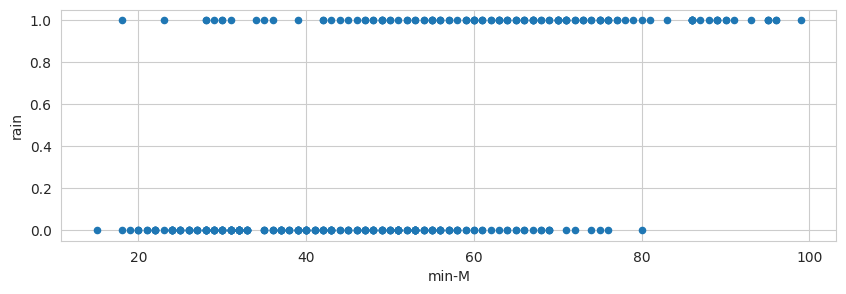

In [46]:
# 散布図 X軸：最低湿度（％：線形） Y軸：降水現象の有無（0:無し、1:有り）
df.plot(figsize=(10, 3), kind='scatter', grid=True, x=df.columns[1], y=df.columns[2])
plt.show()


intercept  : -5.25429137264403
coefficient: 0.0890115222159052
x_border   : 59.029339593803236


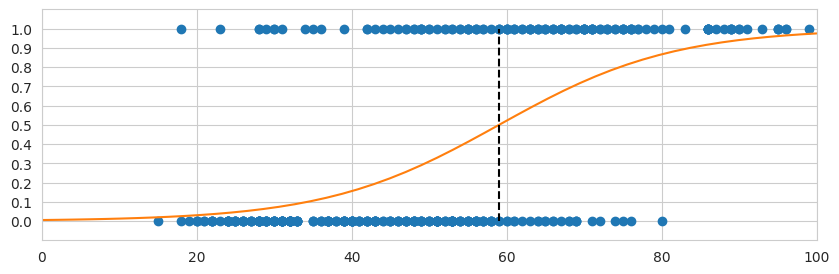

In [47]:
# scikit-learnのLogisticRegressionモデルを適用した結果　（コード引用：TauStation http://taustation.com/logistic-regression/）
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# 説明変数:最低湿度、目的変数:降水現象
X = np.array(df['min-M']).reshape(-1, 1)
y = df['rain']

# C:正則化強度=1e5, , L2正則化を指定してロジスティック回帰モデラーを構築して最適化実行
logreg = LogisticRegression(C=1e5, solver='lbfgs')
logreg.fit(X, y)

# 回帰係数、50%しきい値を表示
b = logreg.intercept_[0]
w = logreg.coef_[0][0]
x_border = 0.0 - b / w
print("intercept  : {}".format(b))
print("coefficient: {}".format(w))
print("x_border   : {}".format(x_border))

# 元データと予測モデルのグラフ描画 
xl = 0
xr = 100
 
x_graph = np.linspace(xl, xr)
y_graph = 1 / (1 + np.exp(- b - w * x_graph))

plt.rcParams["figure.figsize"] = [10,3]
fig, ax = plt.subplots()
 
ax.scatter(X, y, c='tab:blue')
ax.plot(x_graph, y_graph, c='tab:orange')
ax.plot([x_border, x_border], [0, 1], c='k', linestyle='dashed')
 
ax.set_xlim(xl, xr)
ax.set_ylim(-0.1, 1.1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.grid(True)
plt.show()
 
# α切片 intercept、β傾き coefficientの推定結果、予測モデルとしての曲線（降水確率）が表示されている。
# 最大尤度推定した結果の確率50%しきい値（湿度）は、x_border として表示されている。

# 湿度が40%，60％，80％の時、降水確率は各々 およそ15%，50％，85%となることがわかる（あくまで確率）
# 曲線の傾きはかなり「なだらか」であるから、湿度を使って雨降りを言い当てるのは（よほどの高湿度の状況以外は）結構難しいと言える。


ロジスティック回帰分析結果から、
$a = -5.254, b = 0.0890$ という推定値が得られたから、最低湿度 $x$ による降水確率 $p(x)$ は、
$$ p(x) = \frac{exp(a+bx)}{1+exp(a+bx)} = \frac{exp(-5.254 + 0.0890x)}{1+exp(-5.254 + 0.0890x)}$$
という予測モデルが得られた。

## 3. 時系列データ分析 [1][2]

回帰分析で扱ったコロナ感染率のデータや、降水現象のデータなどは、いずれも「時点」を固定した上で対象から得られたデータである。このようなデータを横断面データ（cross sectional data) という。

これに対して、時間軸上で（時間の流れに沿って連続的に）得られたデータを、**時系列データ**(time series data) という[2]。何かを目的変数にすることが無いから、いわゆるノンパラメトリック分析に相当する。


### 3.1 時系列データの概要

時系列データ $y$ が1期から$N$期まであるときに、これらを $y_1, y_2, \cdots, y_N$ のように表す。表現自体はこれまでのデータと同じだが、時系列データの場合は**時間軸上で添え字の順番にデータが出現している**という点が違う。
分析をする上でも、**時間軸上での変化率や周期が興味の対象である**ことが多い。
時系列データを折れ線グラフで可視化したものを**時系列グラフ**(time series chart)という[2]。

<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=34"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_034.jpg' alt='時系列データ' width='640' border='1'></a>
</figure>


### 3.2 ピリオドグラムとパワースペクトル

一般的に、変動過程の パワースペクトル密度 (Power Spectrum Density; PSD) を推定する 1つの方法は、過程のサンプルの離散フーリエ変換を求め (通常は FFT を使用)、結果の振幅の 2乗を適宜スケーリングするというものである。この推定は、"ピリオドグラム" と呼ばれる。

* [MathWorks - ノンパラメトリック推定法](https://jp.mathworks.com/help/signal/ug/nonparametric-methods.html)

ピリオドグラムに似たものとしてパワースペクトルがある。
パワースペクトルはピリオドグラムと違って連続関数になるが、時系列モデルを推定することによって求められる。
パワースペクトルでも同様な周波数にピークが⾒られる[2]。


<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=35"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_035.jpg' alt='時系列データ' width='640' border='1'></a>
</figure>

<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=38"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_038.jpg' alt='時系列データ' width='640' border='1'></a>
</figure>

### 3.3 時系列データの変動分解、周期性の除去（移動平均）

<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=39"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_039.jpg' alt='時系列データ' width='640' border='1'></a>
</figure>

<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=40"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_040.jpg' alt='時系列データ' width='640' border='1'></a>
</figure>

#### Pythonによる時系列データの変動分解の実装例

東京都のコロナ感染者数（2021年4月8日までの過去312日間）のデータを抽出したもの。

* [オリジナルデータとプログラム例（公開教材[1]ただし実装はR）](https://github.com/MDASH-shinshu/MDASH-T-DS/tree/main/4/resources/additional_material/)

In [ ]:
# CSVデータを カレントディレクトリ直下のフォルダ（一時作業領域）へダウンロードする．
!wget -nc https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/resources/Covid-19_tokyo_20210408.csv

# wgetしなくても，Google colab.の左メニュー [ファイル] アイコンをクリックして，ブラウザへファイルをドラッグ＆ドロップしても可

# ファイル (udon.csv)がダウンロード・配置できたことを確認する
!ls -al ./

In [49]:
# オリジナルのCSVファイルをpandasで読み込んでデータフレームdfに格納
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('Covid-19_tokyo_20210408.csv', header=None, dtype='float')
df.columns = ['positive']
df.head()

,positive
0,13.0
1,34.0
2,12.0
3,28.0
4,20.0


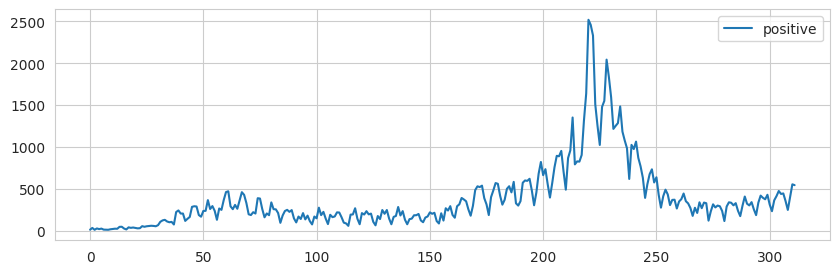

In [50]:
# 折れ線グラフの描画（Y軸：線形）
df.plot(grid=True, y=df.columns[0])
plt.show()

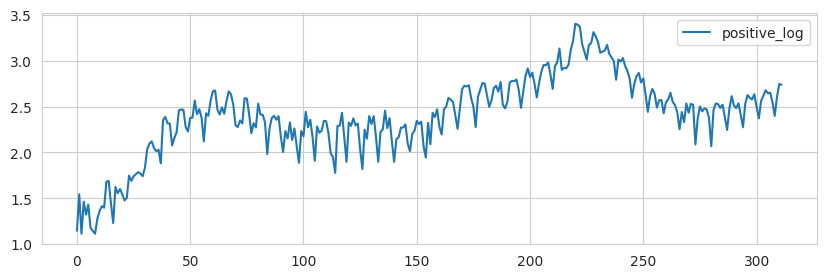

In [51]:
# 対数化したxデータ列を追加
df['positive_log'] = np.log10(df['positive'] + 1)

# 折れ線グラフの描画（Y軸：対数）
df.plot(grid=True, y=df.columns[1])
plt.show()


#### statsmodels API - Lomb-Scargle ピリオドグラムで周期性解析を行う

* [東京大学 - Lomb-Scargle ピリオドグラム 周期性解析](https://ea.c.u-tokyo.ac.jp/astro/Members/yoshida/jisshu1/2019/no7.pdf)

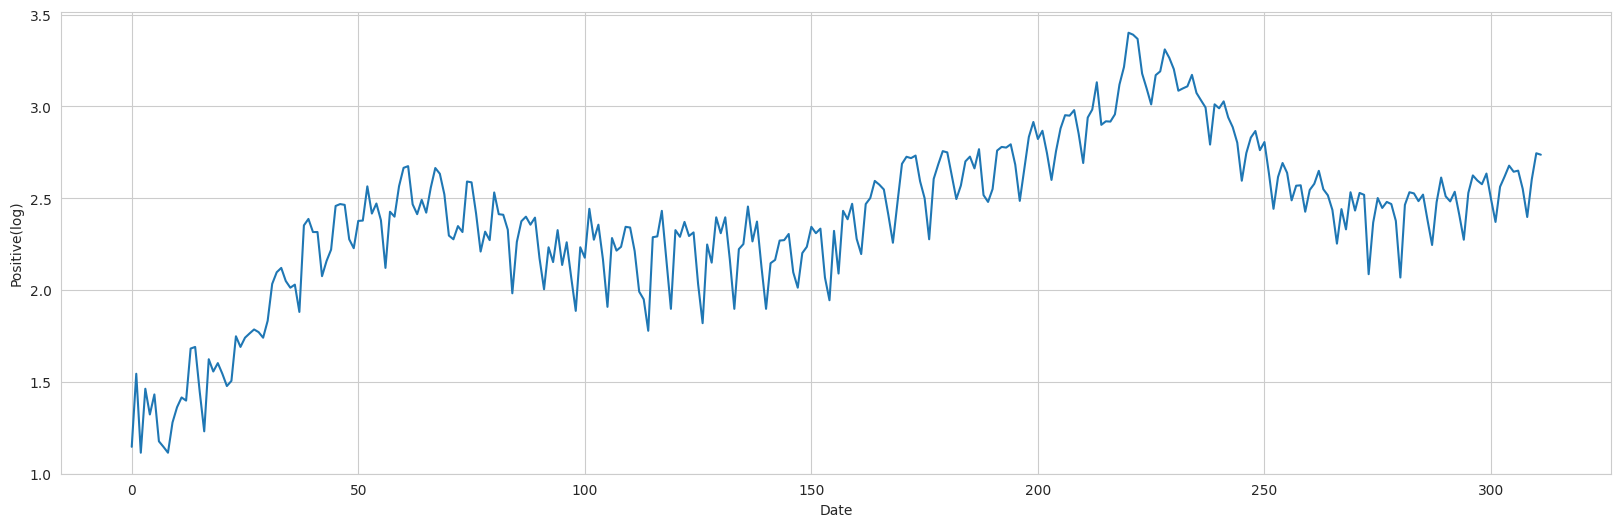

In [52]:
# Scipy の Lomb-Scargle ピリオドグラムを使う - コード引用 https://zenn.dev/chimuichimu/articles/954fc680a6252f

# データのロードと時系列プロット
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.signal as signal

x = list(range(len(df)))
y = df['positive_log']

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Date")
ax.set_ylabel("Positive(log)")
ax.plot(x, y)

fig.show()

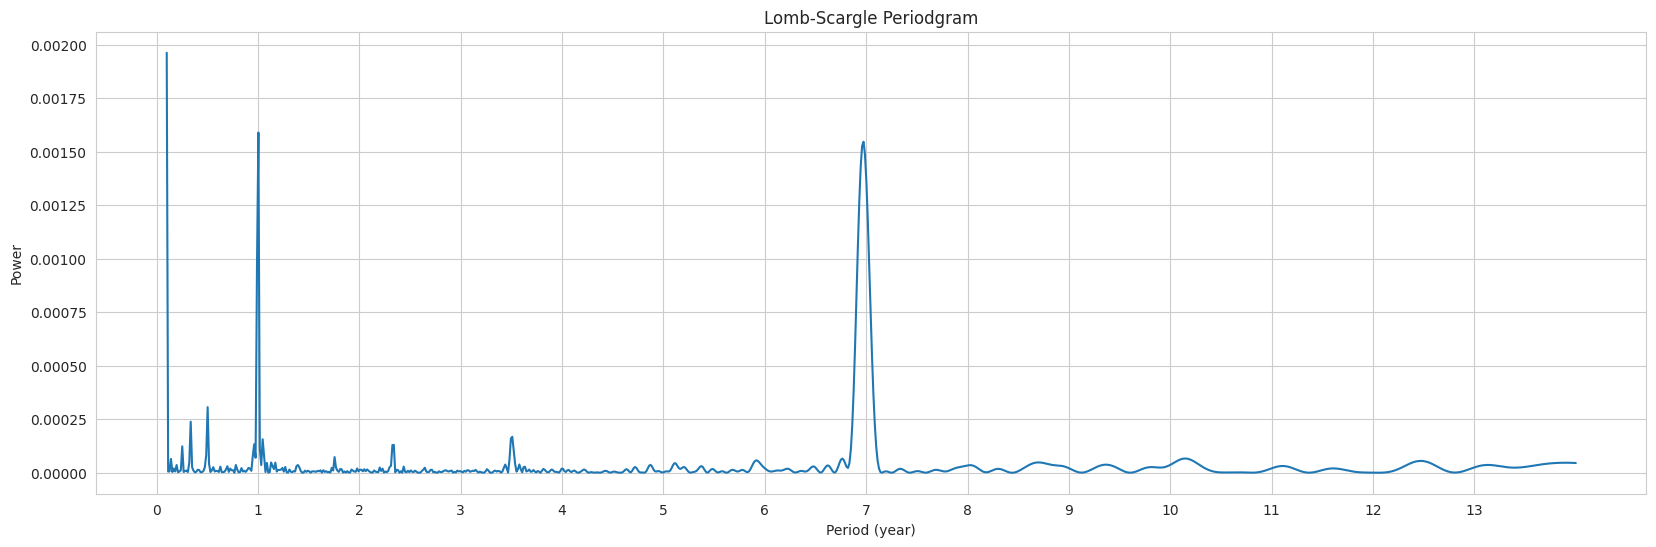

In [53]:
# Lomb-Scargle ピリオドグラムの計算と出力
periods = np.linspace(0.1, 14, 1000)
ang_freq = 2 * np.pi / periods

pgram = signal.lombscargle(
    x, 
    y, 
    ang_freq,
    precenter = True,
    normalize = True
)

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1,1,1)
ax.set_title("Lomb-Scargle Periodgram")
ax.set_xlabel("Period (year)")
ax.set_ylabel("Power")
ax.set_xticks(np.arange(0,14))
ax.plot(periods, pgram)

fig.show()
# 周期性解析の結果、7日でのパワースペクトルが存在することがわかる（検査状況の関係）

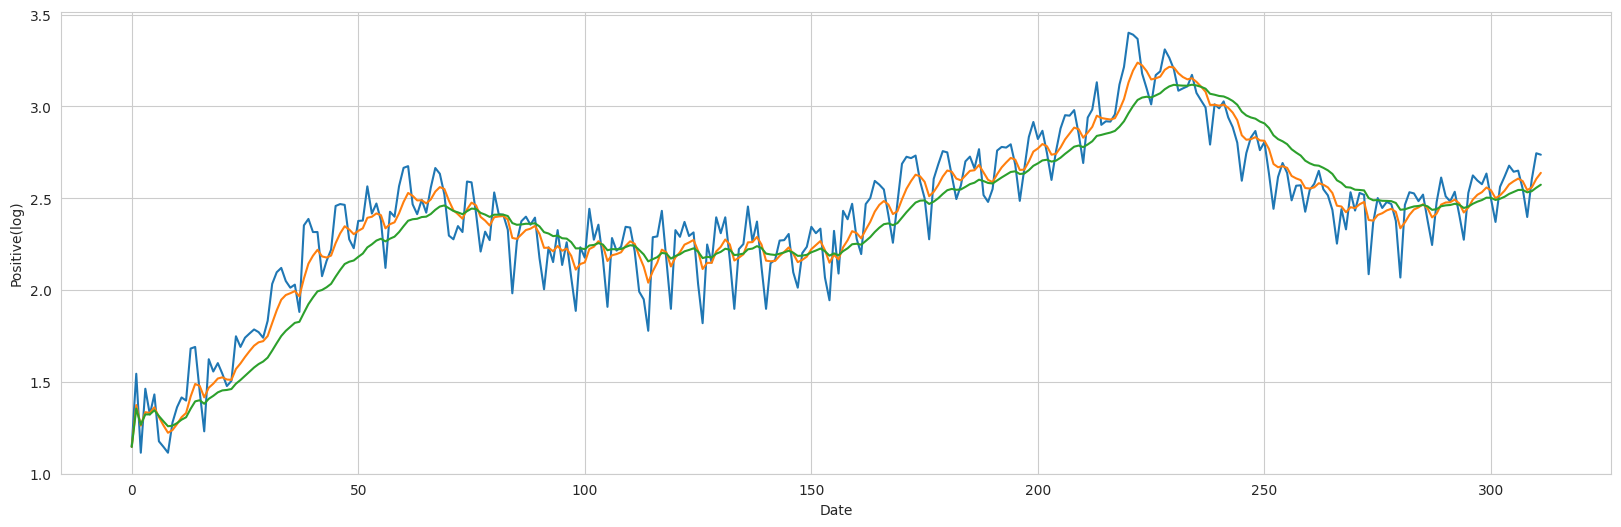

In [54]:
# 指数平滑移動平均の計算（1週間、3週間）
df_ewm7 = df.ewm(span=7).mean()
df_ewm21 = df.ewm(span=21).mean()
y_ewm7 = df_ewm7['positive_log']
y_ewm21 = df_ewm21['positive_log']

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Date")
ax.set_ylabel("Positive(log)")
ax.plot(x, y)
ax.plot(x, y_ewm7)
ax.plot(x, y_ewm21)

fig.show()

### 3.3 自己相関関数、自己回帰予測モデル(AR)

自己回帰モデルは時点 $t$ におけるモデル出力が時点 $$ 以前のモデル出力に依存する確率過程である。
AutoRegressiveと書かれることから ARモデルと呼ばれることが多い。

* [Wikipedia 自己回帰モデル](https://ja.wikipedia.org/wiki/%E8%87%AA%E5%B7%B1%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB)


<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=42"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_042.jpg' alt='時系列データ' width='640' border='1'></a>
</figure>

<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=43"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_043.jpg' alt='時系列データ' width='640' border='1'></a>
</figure>

<figure>
<a href="http://www.mi.u-tokyo.ac.jp/pdf/1-4_data_analysis.pdf#page=44"><img src='https://raw.githubusercontent.com/MDASH-shinshu/MDASH-T-DS/main/4/UTAI-text/JPEG/1-4_data_analysis_044.jpg' alt='時系列データ' width='640' border='1'></a>
</figure>

#### Python : statsmodels API - SARIMAモデルの推定

ARモデル (AutoRegressive model) 、MAモデル（移動平均自己回帰）を組み合わせたARMAモデルは定常な時系列のモデルである。

ARIMAモデル (AR Integrated MA model)は、d階差分をとった系列に対してARMA(p,q)を考えるモデルをARIMA(p,d,q)モデルという。

ARIMAモデルに周期成分を取り入れたモデルをSARIMAモデル (Seasonal ARIMA model) という。


* [時系列分析～統計的手法編～](https://note.com/yiida/n/n6210246ec5b0)
* [Pythonによる時系列分析の基礎](https://logics-of-blue.com/wp-content/uploads/2017/05/python-time-series-analysis-notebook.html)
* [自動SARIMAモデル推定](https://logics-of-blue.com/python-time-series-analysis/)

In [55]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

x = list(range(len(df)))
ts = df['positive_log']

# 差分系列を生成
diff = ts - ts.shift()
diff.head()

0         NaN
1    0.397940
2   -0.430125
3    0.348455
4   -0.140179
Name: positive_log, dtype: float64

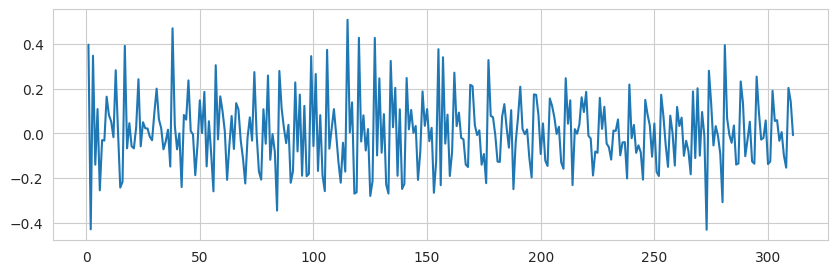

In [56]:
# 差分系列のグラフ
plt.plot(diff)

In [57]:
# 自己相関を求める
ts_acf = sm.tsa.stattools.acf(ts, nlags=40)
ts_acf

array([1.        , 0.9155014 , 0.87041819, 0.82172459, 0.81118472,
       0.82082926, 0.83826006, 0.85556755, 0.79517577, 0.74035821,
       0.69732151, 0.67838449, 0.68384897, 0.69023149, 0.70953348,
       0.6477325 , 0.59607264, 0.54541697, 0.53147294, 0.53541749,
       0.54434315, 0.55243302, 0.48822045, 0.43017861, 0.38814244,
       0.37123419, 0.37868416, 0.38791938, 0.4013801 , 0.34281804,
       0.28964865, 0.24612147, 0.23637363, 0.24713153, 0.2634983 ,
       0.28157731, 0.22610229, 0.18321231, 0.14283332, 0.14079228,
       0.16339431])

In [58]:
# 偏自己相関
ts_pacf = sm.tsa.stattools.pacf(ts, nlags=40, method='ols')
ts_pacf

array([ 1.        ,  0.91735784,  0.19491124,  0.0647045 ,  0.2432846 ,
        0.32001594,  0.29544559,  0.39504332, -0.30917212, -0.16109992,
       -0.06553603, -0.0674709 , -0.01422699, -0.01310337,  0.1290742 ,
       -0.33713239, -0.11872846, -0.10579477, -0.01293775, -0.03282639,
        0.06225134,  0.08911206, -0.08884776, -0.10846755, -0.02993439,
       -0.01963478,  0.05828968,  0.06822663,  0.1690647 , -0.01163012,
       -0.04549511, -0.05885879, -0.00615196, -0.02365197,  0.06546365,
        0.16665328, -0.08620062,  0.01203034, -0.03131979, -0.00349737,
        0.08090741])

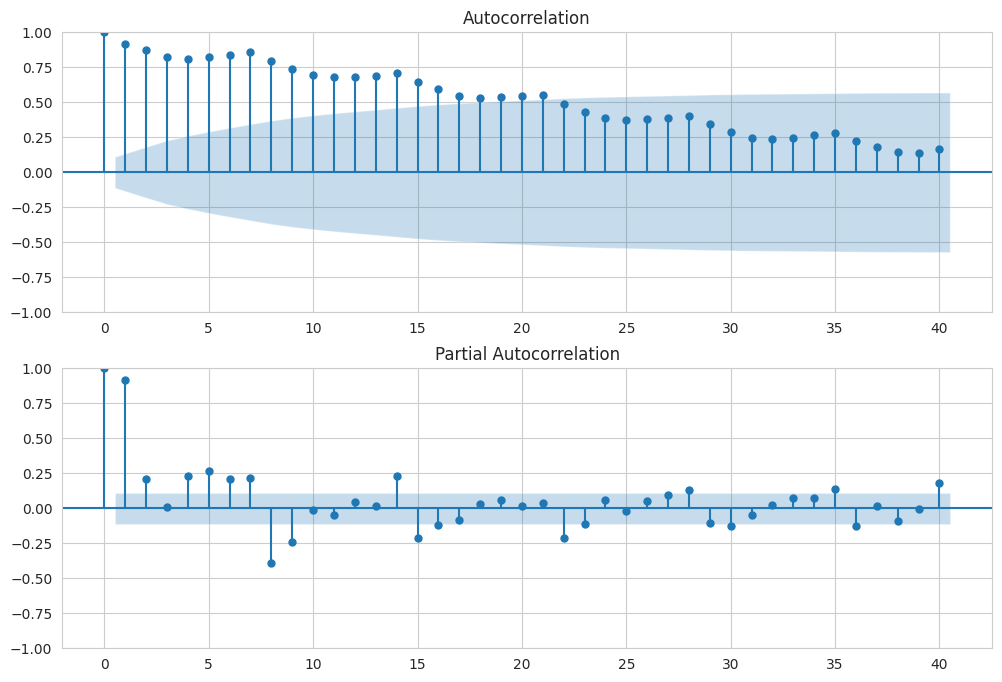

In [59]:
#  自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)
# 7日間の周期性が見られることがわかる。

#### ARIMAモデルの推定（差分実行）

In [60]:
# 差分系列への自動ARMA推定関数の実行
resDiff = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='n')
resDiff
# ARMA(3,2)が最も良いということとなった。

{'aic':             0           1           2
 0 -251.983322 -276.382971 -300.452503
 1 -265.739141 -302.656477 -301.834482
 2 -266.014350 -303.642036 -299.291091
 3 -285.671419 -329.258213 -404.646174
 4 -319.189936 -345.894779 -340.576677,
 'aic_min_order': (3, 2)}

In [61]:
# p=3, q=2 が最善となったので、それをモデル化
from statsmodels.tsa.arima_model import ARIMA
ARIMA_3_1_2 = sm.tsa.ARIMA(ts, order=(3, 1, 2)).fit()
ARIMA_3_1_2.params

ar.L1     0.656500
ar.L2    -0.273017
ar.L3    -0.566451
ma.L1    -1.239816
ma.L2     0.902200
sigma2    0.014451
dtype: float64

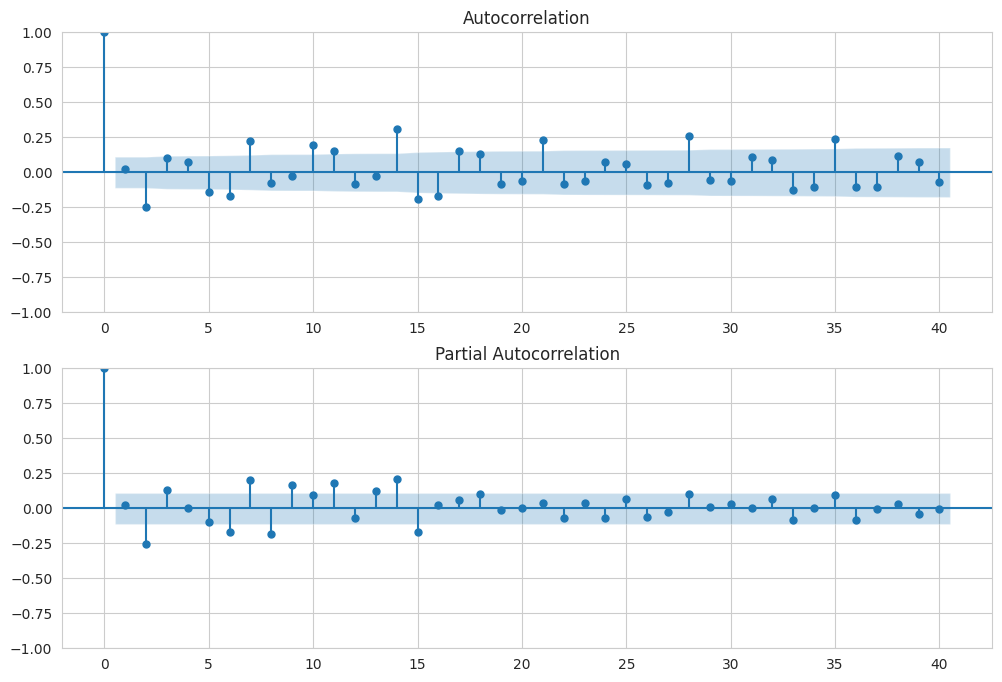

In [62]:
# 残差のチェック
resid = ARIMA_3_1_2.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
# 7日間の周期性に関する残差がかなり抑えられているが、完全には除去できていないことがわかる。

#### SARIMAモデルの推定(季節性・周期性トレンドを入れた自己回帰予測モデル)

In [63]:
# SARIMAモデルを「決め打ち」で推定する
import statsmodels.api as sm

SARIMA_3_1_2_111 = sm.tsa.SARIMAX(ts, order=(3,1,2), seasonal_order=(1,1,1,12)).fit(method='bfgs', maxiter=300)
print(SARIMA_3_1_2_111.summary())

         Current function value: -0.437194
         Iterations: 9
         Function evaluations: 78
         Gradient evaluations: 66
                                      SARIMAX Results                                       
Dep. Variable:                         positive_log   No. Observations:                  312
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 136.405
Date:                              Fri, 05 May 2023   AIC                           -256.809
Time:                                      11:48:49   BIC                           -227.205
Sample:                                           0   HQIC                          -244.960
                                              - 312                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

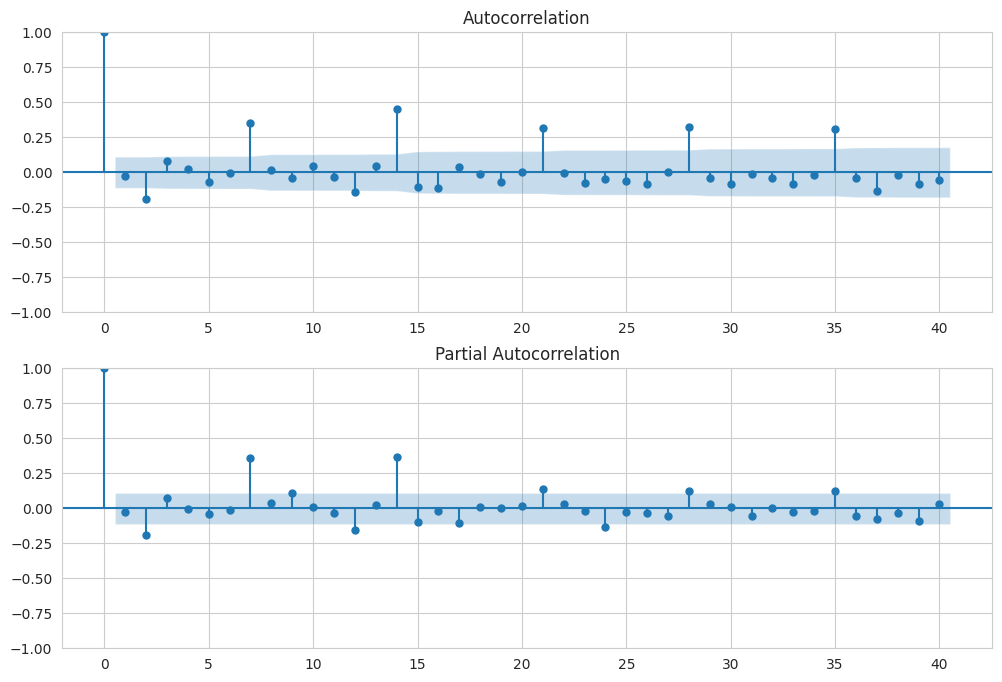

In [64]:
# 残差のチェック
residSARIMA = SARIMA_3_1_2_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)
# 7日間の周期性に関する残差は、ほぼ完全には除去できていることがわかる。

In [65]:
# 実験：261日から312日までを SARIMAモデルによって予測する
pred = SARIMA_3_1_2_111.predict(261, 312)
print(pred)

261    2.538752
262    2.604206
263    2.642641
264    2.559013
265    2.539481
266    2.523976
267    2.378085
268    2.440842
269    2.471830
270    2.496491
271    2.532967
272    2.438957
273    2.511050
274    2.222316
275    2.283136
276    2.539896
277    2.525389
278    2.466622
279    2.457521
280    2.374547
281    2.192326
282    2.362220
283    2.630791
284    2.484326
285    2.418373
286    2.447832
287    2.419012
288    2.267033
289    2.462614
290    2.648147
291    2.540254
292    2.402210
293    2.502175
294    2.455462
295    2.352724
296    2.455945
297    2.624633
298    2.576077
299    2.526462
300    2.543486
301    2.552138
302    2.423661
303    2.530200
304    2.623309
305    2.662775
306    2.612800
307    2.623791
308    2.545199
309    2.433418
310    2.558383
311    2.760047
312    2.710826
Name: predicted_mean, dtype: float64


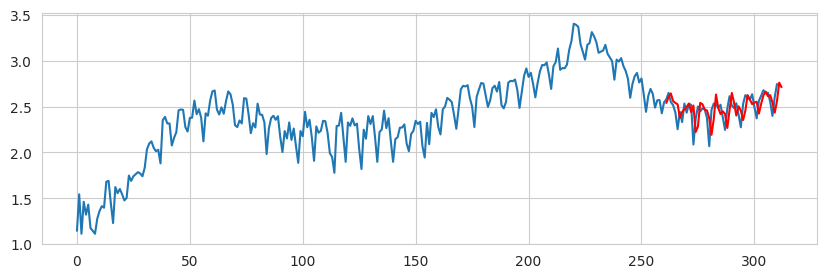

In [66]:
# 実データと予測結果の図示
plt.plot(ts)
plt.plot(pred, "r")
# 長期トレンド、中期トレンド、7日間周期性など、大変よく予測できていることがわかる！

# memo